# Distribución geográfica de causas judiciales CABA - ODSLA - Desafío 1

## Introducción

Este notebook forma parte del Desafío ODSLA 1. El objetivo del desafío es distribuir de forma más equitativa las tareas entre los distintos juzgados del fuero Penal, Contravencional y de Faltas de la Ciudad Autónoma de Buenos Aires. Al hacerlo deberán tener en cuenta: Minimizar la distancia del juzgado con el lugar donde ocurre el hecho (lat/lon) Evitar discrecionalidades ni pasos “manuales” en la asignación de las causas, idealmente tener en cuenta los tiempos de procesamiento de los distintos delitos (artículo y tiempo del expediente) a fin de intentar que la distribución de las tareas más duras también sea proporcional.

En este notebook se exploran varios aspectos de la base de datos correspondiente en función de la distribución geográfica de los data points.

## Librerías y dataset

In [1]:
import time
time_init = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('penal_df.xlsx')

In [4]:
df.head()

,org_idradactual,exp_cuij,org_idintpri,org_cod_pri,org_descorta_pri,org_descr_Pri,org_idintseg,est_id,est_descr,exp_anio,...,den_v_domestica,den_v_genero,den_zon_id,den_zona,filter_.,org_destino_act,PrimarioDen_id,PrimarioDen_id_oju,PrimarioExp_id,PrimarioExp_oju
0,72,01-00042685-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
1,72,01-00039012-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
2,72,01-00035028-8,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
3,72,01-00036824-1,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
4,72,01-00034124-6,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1


In [5]:
df.columns

Index(['org_idradactual', 'exp_cuij', 'org_idintpri', 'org_cod_pri',
       'org_descorta_pri', 'org_descr_Pri', 'org_idintseg', 'est_id',
       'est_descr', 'exp_anio', 'exp_cuerpos', 'exp_fojas', 'exp_detenidos',
       'exp_id', 'exp_sufijo', 'exp_fechecho', 'exp_fecinidem', 'exp_fecini',
       'exp_fecreg', 'exp_fecsor', 'exp_fecelev', 'exp_letra', 'oju_id',
       'oju_descr', 'exp_ultmov', 'exp_ultmovf', 'den_id', 'den_cod_casoMPF',
       'Tipo_ingreso_MPF', 'org_cod', 'org_descr', 'org_descorta', 'org_den',
       'org_descorta_Den', 'org_descr_Den', 'den_flagrante', 'Comuna',
       'den_barrio', 'den_calle_id', 'den_cod_postal', 'den_fec_hecho',
       'den_fec_ingreso_MPF', 'den_fec_ini_comi', 'den_hora_hecho',
       'den_latitud', 'den_longitud', 'den_tipo_den', 'den_loc_id',
       'den_sin_lugar_hecho', 'den_v_domestica', 'den_v_genero', 'den_zon_id',
       'den_zona', 'filter_.', 'org_destino_act', 'PrimarioDen_id',
       'PrimarioDen_id_oju', 'PrimarioExp_id', 'Pri

### Mapas: Barrios y Comunas

En este apartado generamos el mapa de las Zonas Judiciales con información de <b>BA Data</b> (archivos .csv con coordenadas de barrios y detalle de Comunas). Usamos las librerías geopandas y Shapely.

In [6]:
import geopandas as gpd
map_df = gpd.read_file('barrios.csv')
map_df.columns

Index(['WKT', 'barrio', 'comuna', 'perimetro', 'area', 'geometry'], dtype='object')

In [7]:
map_df[['barrio','geometry','comuna']].head()

,barrio,geometry,comuna
0,CHACARITA,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...",15
1,PATERNAL,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...",15
2,VILLA CRESPO,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...",15
3,VILLA DEL PARQUE,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...",11
4,ALMAGRO,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...",5


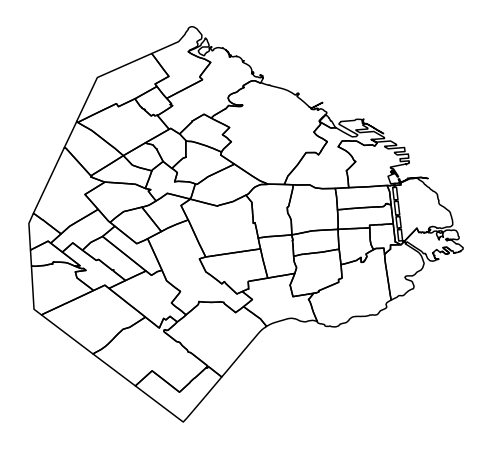

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 8))
map_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

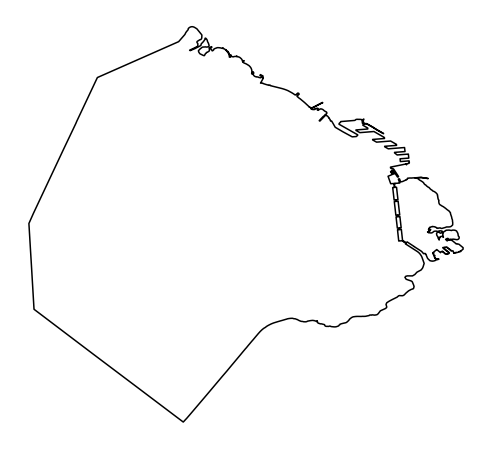

In [9]:
# Mapa de CABA
from shapely.ops import unary_union
polygons = [map_df.at[i,'geometry'] for i in range(map_df.shape[0])]
caba_polygon = unary_union(polygons)
caba_df = gpd.GeoDataFrame()
caba_df['geometry'] = [caba_polygon]
# Pequeña correcion a la geometría
epsilon = 10**(-12)
caba_df['geometry'] = caba_df['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

## Geolocalización de causas

### Dataset a utilizar

Utilizo un df que contenga solamente las causas con coordenadas. Reseteo los índices, pero me quedo los originales por si necesito comparar con mi df original. Todas las inferencias geográficas que podamos hacer dependerán del proceso generador de las coordenadas NaNs, de modo que en un apartado posterior lo exploramos con algún detalle.  

In [10]:
geo_df = df[~((df['den_latitud'] == 'unknown') | (df['den_longitud'] == 'unknown'))]
geo_df = geo_df.reset_index()
geo_df.loc[:,['den_latitud','den_longitud']].head()

,den_latitud,den_longitud
0,-58.48,-34.62
1,-58.51,-34.67
2,-58.44,-34.67
3,-58.44,-34.67
4,-58.36,-34.63


In [11]:
geo_df.shape

(11119, 60)

In [12]:
df[['den_latitud','den_longitud']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37136 entries, 0 to 37135
Data columns (total 2 columns):
den_latitud     37136 non-null object
den_longitud    37136 non-null object
dtypes: object(2)
memory usage: 580.4+ KB


In [13]:
# Convierto coordenadas a float (ahora son object)
try:
    geo_df['den_latitud'] = geo_df['den_latitud'].apply(lambda x: float(x))
    geo_df['den_longitud'] = geo_df['den_longitud'].apply(lambda x: float(x))
except:
    print('Cannot convert')

### Imprecisión en las coordenadas

El dataset contiene un alto grado de imprecisión en las coordenadas geográficas, que se han truncado a dos decimales. <b>(Ese fue mi entendimiento en la conversación con el juez Pablo Casas, habría que chequear que estén truncadas y no redondeadas; en lo que sigue trabajo con ese supuesto, con una pequeña correción podría transformarse al caso de redondeo).</b> 

Para poder visualizar contemplando esta imprecisión, a cada causa le asigno un polígono que contemple el truncamiento. Por ejemplo, si <b>den_latitud</b> es -58.48, podría ir de -58.4800 a -58.4899 (haremos -58.49). Entonces defino una función que genere un polígono contamplando esta amplitud. A cada "punto" del dataset la función le asignará un cuadrado que vaya entre sus posibles valores. Por ejemplo, al punto (-58.48,-34.62) le asignará el cuadrado con coordenadas (-58.48,-34.62), (-58.48,-34.63), (-58.49,-34.63), (-58.49,-34.62) (ver ejemplo gráfico en mapa).

In [14]:
from shapely.geometry import Point, Polygon
def point_to_poly(lat, lon):
    poly = Polygon([(lat,lon),(lat,lon-0.01),(lat-0.01,lon-0.01),(lat-0.01,lon)])
    return poly

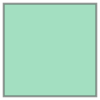

In [15]:
point_to_poly(-58.48,-34.62)

Me gustaría ver qué grado de incertidumbre implica esta información. Vamos a medir cada lado del cuadrado con una aproximación euclideana.

In [16]:
def distance(lon1,lat1,lon2,lat2):
    # Longitud aprox de meridianos / paralelos en metros
    deglen = 110500
    delta_x = lat1 - lat2
    delta_y = (lon1 - lon2)*np.cos((lat1 + lat2) / 2)
    return deglen*((delta_x)**2 + (delta_y)**2)**(0.5)

print(f'Distancia de un lado (aprox): {round(distance(-58.48,-34.62,-58.48,-34.63))} m')

Distancia de un lado (aprox): 1105.0 m


Es decir, es un cuadrado de aproximadamente 1100 de largo.

In [17]:
# Construcción de geometry para geopandas
geometry = []
for i in range(geo_df.shape[0]):
    lat = geo_df.at[i,'den_latitud']
    lon = geo_df.at[i,'den_longitud']
    geometry.append(point_to_poly(lat,lon).intersection(caba_polygon))
geo_df = gpd.GeoDataFrame(geo_df,geometry=geometry)

### Errores

Vamos a limpiar el dataset de errores: hay coordenadas que no corresponden a CABA.

In [18]:
from shapely.geometry import Point, Polygon
# Chequeo los que tengan intersección nula
cuenta = 0
for i in range(geo_df.shape[0]):
    if geo_df.loc[i,'geometry'].is_empty:
        cuenta += 1
        geo_df.drop(i,inplace=True)
geo_df = geo_df.reset_index(drop=True)
print(f'Se removieron {cuenta} instancias con error.')

Se removieron 1019 instancias con error.


### Agrupación por zona y ploteo

La información así organizada nos divide a la Ciudad de Buenos Aires en una grilla de cuadrículas geográficas que estudiaremos a lo largo de este notebook. A continuación usamos los polígonos generados como variable de agrupamiento, para así calcular índices representativos de la distribución geográfica. Empezamos por la cantidad de casos.

In [19]:
from shapely import wkt

geo_df_pd = pd.DataFrame(geo_df)
for i in range(geo_df_pd.shape[0]):
    geo_df_pd.at[i,'str_geometry'] = str(geo_df_pd.at[i,'geometry'])
casos_geometry = geo_df_pd['str_geometry'].value_counts()
casos_geometry = casos_geometry.to_frame().reset_index(drop=False)
casos_geometry = casos_geometry.rename(columns={'index':'polygon','str_geometry':'casos'})
casos_geo_df = gpd.GeoDataFrame(casos_geometry['casos'], geometry=casos_geometry['polygon'].apply(wkt.loads))
casos_geo_df.head()

,casos,geometry
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6..."
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6..."
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6..."
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6..."
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6..."


In [20]:
casos_geo_df.shape

(210, 2)

In [21]:
casos_geo_df['coords'] = casos_geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
casos_geo_df['coords'] = [coords[0] for coords in casos_geo_df['coords']]
casos_geo_df.head()

,casos,geometry,coords
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6...","(-58.394999999999996, -34.605000000000004)"
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6...","(-58.385000000000005, -34.605000000000004)"
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6...","(-58.41499999999999, -34.614999999999995)"
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6...","(-58.41499999999999, -34.625)"
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6...","(-58.394999999999996, -34.614999999999995)"


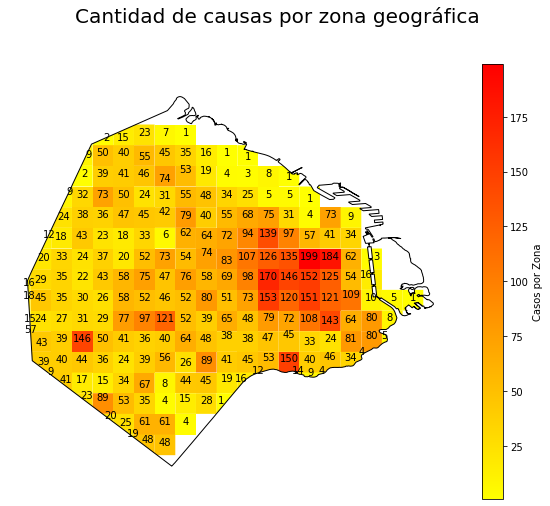

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                  legend_kwds={'label': "Casos por Zona",})
# Labeleo el nombre a cada comuna
for idx, row in casos_geo_df.iterrows():
    plt.annotate(s=row['casos'], xy=row['coords'],
                 horizontalalignment='center')
fig.suptitle('Cantidad de causas por zona geográfica',size=20)
ax.axis('off')
plt.savefig('Causas_por_zona.png')
plt.show()

Este heatmap nos da una idea general de donde hay mayor densidad de causas (notar que coincide con las conclusiones del apartado "Comparación entre Zonas judiciales"). La otra pregunta interesante con estos datos es el tamaño promedio de las causas (vinculada con la "carga de trabajo").

### Fojas promedio por Zona geográfica

In [23]:
fojas_median_geometry = geo_df.groupby('str_geometry').median()['exp_fojas']
fojas_median_geometry = fojas_median_geometry.to_frame().reset_index(drop=False)
fojas_median_geo_df = gpd.GeoDataFrame(fojas_median_geometry['exp_fojas'], 
                                     geometry=fojas_median_geometry['str_geometry'].apply(wkt.loads))
fojas_median_geo_df.head()

,exp_fojas,geometry
0,24.0,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,1.0,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,53.0,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66.0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,1.0,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6..."


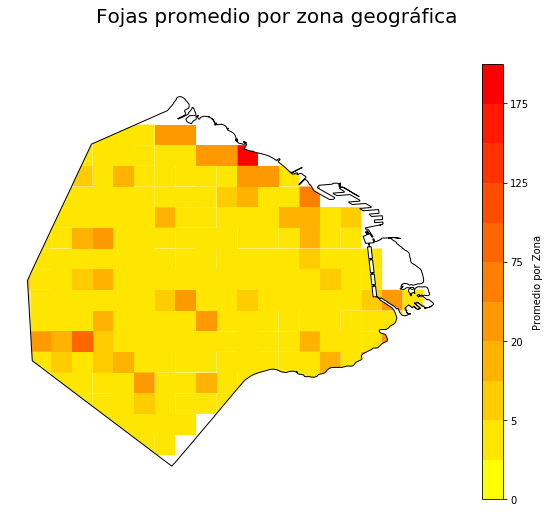

In [24]:
import matplotlib.colors as colors

fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
bounds = np.array([0,1,5,10,20,50,75,100,125,150,175,200,])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fojas_median_geo_df.plot(ax=ax,column='exp_fojas',zorder=1,
                         legend=True,cmap='autumn_r',norm=norm,
                        legend_kwds={'label': "Promedio por Zona",})

fig.suptitle('Fojas promedio por zona geográfica',size=20)
ax.axis('off')
plt.show()

Podríamos investigar los valores grandes en detalle como parte de nuestro entendimiento del problema de la "carga de trabajo" (a lo mejor me están indicando algo valioso). Por lo demás, la conclusión es que el tamaño de las causas es bastante uniforme geográficamente, con lo cual la cantidad de causas es una variable mucho más relevante a la hora de la distribución geográfica. A su vez, pareciera haber una leve correlación negativa entre el tamaño promedio de las causas y su cantidad en cada cuadrícula. Veamos.

### Correlación entre cantidad de casos y fojas promedio

In [25]:
merge_df = fojas_median_geo_df.merge(casos_geo_df,on='geometry')
merge_df.head()

,exp_fojas,geometry,casos,coords
0,24.0,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000...",5,"(-58.354294088366956, -34.62506061114897)"
1,1.0,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000...",8,"(-58.35655385118322, -34.63466414848245)"
2,53.0,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000...",4,"(-58.3697100558266, -34.65118001337335)"
3,66.0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000...",1,"(-58.394999999999996, -34.57686555016434)"
4,1.0,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6...",1,"(-58.345, -34.624771429289495)"


In [26]:
merge_df[['exp_fojas','casos']].corr()

,exp_fojas,casos
exp_fojas,1.000000,-0.137002
casos,-0.137002,1.000000


In [27]:
from scipy.stats import pearsonr

results = pearsonr(merge_df['exp_fojas'],merge_df['casos'])
print(f'Coeficiente de correlación de Pearson: ',results[0])
p = results[1]
print(f'p-value: ',results[1])
if p < 0.05:
    print('Correlación significativa al 5%')

Coeficiente de correlación de Pearson:  -0.13700170730179412
p-value:  0.047383874301681346
Correlación significativa al 5%


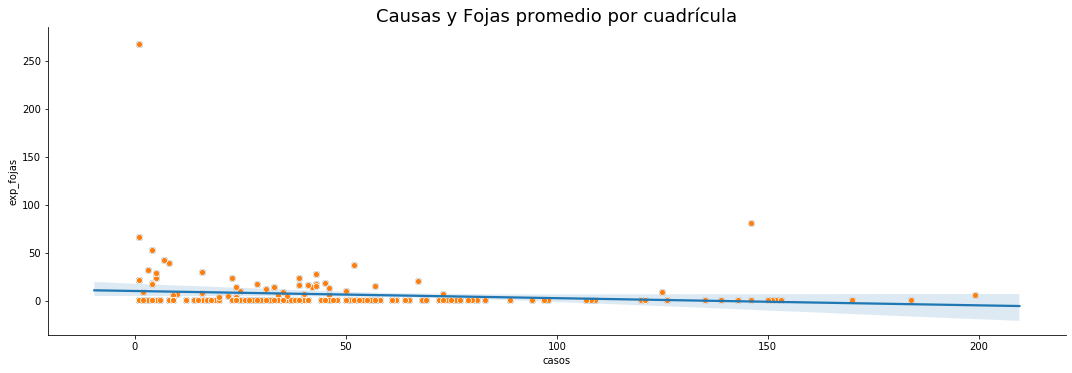

In [28]:
sns.lmplot('casos', 'exp_fojas', data=merge_df, height=5, aspect=3)
sns.scatterplot('casos', 'exp_fojas', data=merge_df)
plt.title('Causas y Fojas promedio por cuadrícula',size=18)
plt.show()

Una forma de interpretar esta correlación es como una consecuencia de la distribución de cantidad de fojas por causa: la mayoría de las causas tiene una foja, de modo que si hay más causas en una zona, lo más probable es que sean de una foja. 

In [29]:
print('Causas según cantidad de fojas')
geo_df['exp_fojas'].value_counts().head(10)

Causas según cantidad de fojas


1     5898
18      84
16      84
15      76
21      75
14      74
22      72
20      69
11      67
10      67
Name: exp_fojas, dtype: int64

Por esta razón, parecería más conveniente usar totales por zona en lugar de causas totales o fojas promedio, ya que sería una variable que nos agrupa ambas características.

### Fojas totales por Zona geográfica

In [30]:
fojas_tot_geometry = geo_df.groupby('str_geometry').sum()['exp_fojas']
fojas_tot_geometry = fojas_tot_geometry.to_frame().reset_index(drop=False)
fojas_tot_geo_df = gpd.GeoDataFrame(fojas_tot_geometry['exp_fojas'], 
                                     geometry=fojas_tot_geometry['str_geometry'].apply(wkt.loads))
fojas_tot_geo_df.head()

,exp_fojas,geometry
0,462,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,161,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,193,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,1,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6..."


In [31]:
for i in range(fojas_tot_geo_df.shape[0]):
    fojas_tot_geo_df.at[i,'exp_fojas'] = int(fojas_tot_geo_df.at[i,'exp_fojas']/100)

In [32]:
fojas_tot_geo_df['coords'] = fojas_tot_geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
fojas_tot_geo_df['coords'] = [coords[0] for coords in fojas_tot_geo_df['coords']]
fojas_tot_geo_df.head()

,exp_fojas,geometry,coords
0,4,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000...","(-58.354294088366956, -34.62506061114897)"
1,1,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000...","(-58.35655385118322, -34.63466414848245)"
2,1,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000...","(-58.3697100558266, -34.65118001337335)"
3,0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000...","(-58.394999999999996, -34.57686555016434)"
4,0,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6...","(-58.345, -34.624771429289495)"


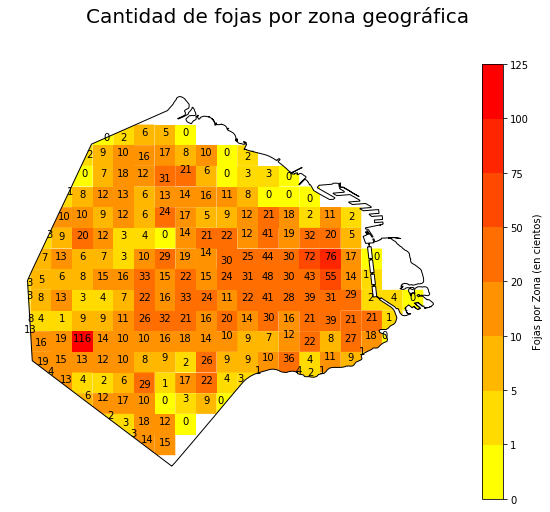

In [33]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
bounds = np.array([0,1,5,10,20,50,75,100,125,])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fojas_tot_geo_df.plot(ax=ax,column='exp_fojas',zorder=1,
                  legend=True,cmap='autumn_r',norm=norm,
                  legend_kwds={'label': "Fojas por Zona (en cientos)",})
# Labeleo el nombre a cada comuna
for idx, row in fojas_tot_geo_df.iterrows():
    plt.annotate(s=row['exp_fojas'], xy=row['coords'],
                 horizontalalignment='center')
fig.suptitle('Cantidad de fojas por zona geográfica',size=20)
ax.axis('off')
plt.show()

La distribución se asemeja a la de las causas, aunque es un poco más uniforme (fruto de la correlación negativa estudiada más arriba). Por otro lado, hay un interesante outlier que valdría la pena estudiar más en detalle.

<b>Idea</b>: repetir todo el análisis, excluyendo las causas de una sola foja. Entender mejor qué son estas causas de una sola foja, porqué hay tantas y como es su "carga de trabajo". A su vez, habría que considerar una cuestión de eficiencia: es posible que la "carga de trabajo por foja" disminuya a medida que aumentan las fojas. Dicho de otra manera, que 18 causas de 1 hoja impliquen más trabajo que 1 causa de 18 hojas. O bien podría suceder al revés, que las causas de una sola foja sean trámites cortos que se resuelven rápidamente. Preguntar al juez Casas.

## Predictores de la distribución de causas

En este apartado exploramos algunas variables que pueden explicar la distribución geográfica de la densidad de causas.

### Población

El primer predictor a analizar es la población, siguiendo la intuición de que a más personas, más conflictos y en consecuencia más causas. Utilizamos información poblacional del Censo 2010 desagregada geográficamente por radio censal (datos de BA Data).  

In [34]:
censo_geodf = gpd.read_file('informacion_censal_por_radio_2010.shp')
censo_geodf.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5..."
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6..."
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6..."
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6..."
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6..."


In [35]:
censo_geodf['Densidad'] = censo_geodf['POBLACI'] / censo_geodf['AREA_KM']

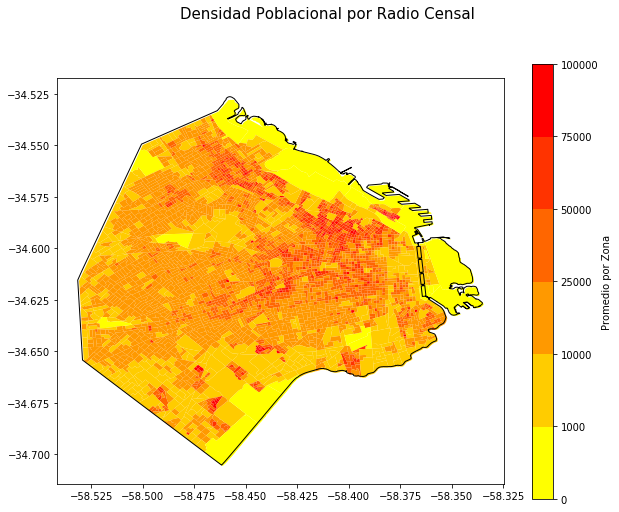

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)

bounds = np.array([0, 1000, 10000, 25000, 50000, 75000, 100000])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
censo_geodf.plot(ax=ax,column='Densidad',zorder=1,
                legend=True,cmap='autumn_r',
                norm=norm,legend_kwds={'label': "Promedio por Zona",})
fig.suptitle('Densidad Poblacional por Radio Censal',size=15)
plt.show()

Parece haber una correlación con la cantidad de causas. Vamos a verlo en más detalle. Vamos a calcular la cantidad de personas que hay en cada una de las cuadrículas de nuestra grilla judicial. Para eso suponemos una distribución uniforme tanto de la población dentro de cada radio censal (supuesto que no es tan grave dado el tamaño relativamente pequeño de los radios censales) como de las causas dentro de cada cuadrícula (supuesto un poco más fuerte dado el tamaño de las cuadrículas pero inevitable con la información que tenemos).

In [37]:
# Interseccion radios censales y casos
import time
time0 = time.time()
casos_radiodf = casos_geo_df
for i in range(casos_radiodf.shape[0]):
    geometry_cuadrado = casos_radiodf.at[i,'geometry']
    poblacion = []
    for j in range(censo_geodf.shape[0]):
        polygon = censo_geodf.at[j,'geometry']
        area_polygon = polygon.area
        area_intersec = geometry_cuadrado.intersection(polygon).area
        poblacion_intersec = area_intersec*censo_geodf.at[j,'POBLACI'] / area_polygon
        poblacion.append(poblacion_intersec)
    casos_radiodf.at[i,'Poblacion'] = np.array(poblacion).sum()


print(f'Tardó: '+str(time.time()-time0))
casos_radiodf.head()

Tardó: 111.59217381477356


,casos,geometry,coords,Poblacion
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6...","(-58.394999999999996, -34.605000000000004)",33115.404760
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6...","(-58.385000000000005, -34.605000000000004)",16361.326489
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6...","(-58.41499999999999, -34.614999999999995)",33405.840046
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6...","(-58.41499999999999, -34.625)",21938.982845
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6...","(-58.394999999999996, -34.614999999999995)",35600.674060


In [38]:
# Chequeo
print(f'Poblacion Censo: '+str(censo_geodf['POBLACI'].sum()))
print(f'Polacion grilla: '+str(casos_radiodf['Poblacion'].sum()))

Poblacion Censo: 2890151.0
Polacion grilla: 2874299.6812284784


La diferencia se debe a que la grilla del dataset de causas no barre todo el área de la Ciudad de Buenos Aires. De todos modos a los efectos de nuestro análisis es suficiente.

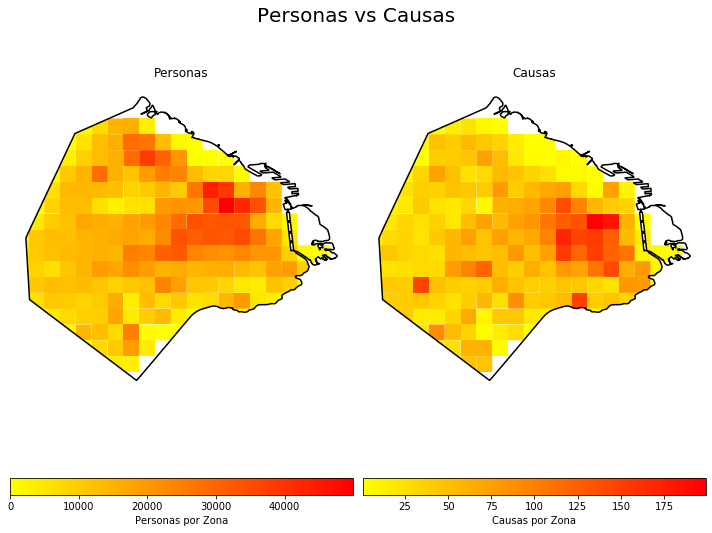

In [39]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
caba_df.boundary.plot(ax=ax[0],edgecolor='0')
caba_df.boundary.plot(ax=ax[1],edgecolor='0')
casos_radiodf.plot(ax=ax[0],column='Poblacion',
                   cmap='autumn_r',legend=True,
                  legend_kwds={'label': "Personas por Zona",
                               'orientation': "horizontal"})
casos_geo_df.plot(ax=ax[1],column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                  legend_kwds={'label': "Causas por Zona",
                              'orientation':'horizontal'})
ax[0].set_title('Personas')
ax[1].set_title('Causas')
ax[0].axis('off'),ax[1].axis('off')
plt.suptitle('Personas vs Causas',size=20)
plt.tight_layout()
plt.show()

In [40]:
print('Correlacion Causas y Poblacion')
casos_radiodf[['casos','Poblacion']].corr()

Correlacion Causas y Poblacion


,casos,Poblacion
casos,1.000000,0.594135
Poblacion,0.594135,1.000000


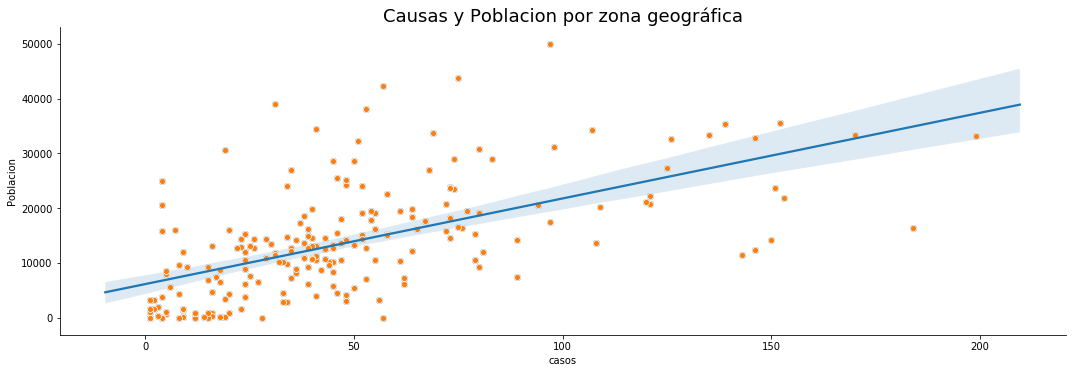

In [41]:
sns.lmplot('casos', 'Poblacion', data=casos_radiodf, height=5, aspect=3)
sns.scatterplot('casos', 'Poblacion', data=casos_radiodf)
plt.title('Causas y Poblacion por zona geográfica',size=18)
plt.show()

In [42]:
results = pearsonr(casos_radiodf['casos'],casos_radiodf['Poblacion'])
print(f'Coeficiente de correlación de Pearson: ',results[0])
p = results[1]
print(f'p-value: ',results[1])
if p < 0.05:
    print('Correlación significativa al 5%')

Coeficiente de correlación de Pearson:  0.5941354522275535
p-value:  1.9908935423007447e-21
Correlación significativa al 5%


Idea: agregar feature de poblacion promedio en cuadrículas adyacentes.

### Densidad de tránsito

La otra variable disponible que podría explicar la cantidad de causas es la densidad de viajes en una zona determinada. Estoy pensando en conflictos que surgen no sólo entre residentes, que está contemplado en el apartado anterior, sino también en personas que se mueven a determinadas zonas por trabajo. En BA Data está la información de cantidad de viajes en subte por estación para poder hacer este análisis.

La procesé previamente en Excel para que queden los viajes entre las 16 y las 21 para el mes de enero de 2019 (una limitación en mi procesamiento del dataset, esto se puede cambiar). 

In [43]:
estaciones = pd.read_excel('viajes_enero2019.xlsx')
estaciones.head()

,Estacion,long,lat,Total Viajes,id,linea
0,9 de julio,-58.380574,-34.604245,187837,6,D
1,Acoyte,-58.436429,-34.618280,290410,42,A
2,Aguero,-58.407161,-34.591628,215771,9,D
3,Alberti,-58.401208,-34.609834,97569,37,A
4,Angel Gallardo,-58.431274,-34.602162,304612,28,B


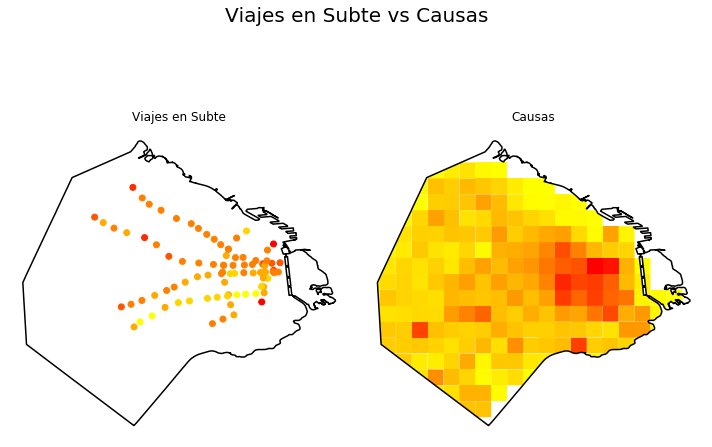

In [44]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
caba_df.boundary.plot(ax=ax[0],edgecolor='0')
caba_df.boundary.plot(ax=ax[1],edgecolor='0')
bounds = np.array([0,50000, 100000,200000,400000,600000,750000,1000000])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax[0].scatter(estaciones.long,estaciones.lat,
            c=estaciones['Total Viajes'],
           cmap='autumn_r',norm=norm,)

casos_geo_df.plot(ax=ax[1],column='casos',zorder=1,
                  cmap='autumn_r',)
ax[0].set_title('Viajes en Subte')
ax[1].set_title('Causas')
ax[0].axis('off'),ax[1].axis('off')
plt.suptitle('Viajes en Subte vs Causas',size=20)
plt.tight_layout()
plt.show()

Nota: parece haber correlación, habría que encontrar un feature adecuado para medir en cada cuadrícula. Es más complejo que en el caso anterior, porque se mezclan distancia con cantidad de viajes, además de que hay estaciones que son trasbordo (Retiro, Constitución, Lacroze, Congreso de Tucumán). Lo que me gustaría tener es una medida de cantidad de personas que trabajan en una zona determinada, y esta información del subte es una aproximación bastante ruidosa a esa idea. No es lo mismo densidad de tránsito que densidad de trabajo, digamos. Mi intuición es que los conflictos que dan lugar a causas judiciales ocurren más probablemente en aquellos lugares donde las personas permanecen durante un tiempo relativamente prolongado, y la densidad de tránsito no necesariamente captura eso. Necesitaría más bien data de los <b>destinos finales</b>. Por lo pronto, no estoy seguro de que aporte mucho más que la densidad poblacional.

## Ideas para la distribución de causas

En este apartado exploramos algunas ideas para la distribución de causas en base a su distribución geográfica. Primero veamos donde están los dos edificios con juzgados.

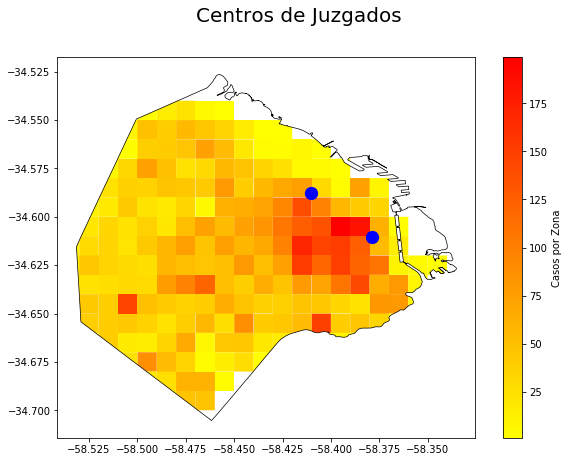

In [45]:
# Tacuari 198 = -34.610357, -58.378970
# Alto Palermo = -34.587686, -58.410279
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],y=[-34.610357,-34.587686],s=150,c='blue')
fig.suptitle('Centros de Juzgados',size=20)
plt.show()

### Propuesta: decision boundary longitud, criterio casos

Propuesta 1: encontrar un decision boundary que divida a la Ciudad en dos, pasando "por el medio" de nuestros dos centros de Juzgados, de modo tal que la "carga de trabajo" a cada lado de la frontera sea igual. Empezamos por la propuesta más sencilla posible, sugerida por los centros de juzgados mismos: que el decision boundary sea una longitud (una línea horizontal). 

"Carga de trabajo" es un concepto que requiere elaboración, según lo conversado en la última reunión. Una idea básica para implementarlo es "cantidad de casos". Otras ideas giran en torno a cantidad de fojas, extensión de las resoluciones, gravedad de los delitos según el Código Penal. Para desarrollar estas otras cuestiones, habría que poder estimar estos valores con algún modelo en el momento de asignar las causas.

Por lo pronto, empezamos con "cantidad de casos", porque es un dato que tenemos y sobre el cual podríamos desarrollar matemáticamente la idea. Esta después sería extensible a otros conceptos de "carga de trabajo". 

In [46]:
lat_max = geo_df['den_latitud'].max()
lat_min = geo_df['den_latitud'].min()
lon_max = geo_df['den_longitud'].max()
lon_min = geo_df['den_longitud'].min()
x_set = np.linspace(lat_min,lat_max)
y_set = -34.6 + 0*x_set

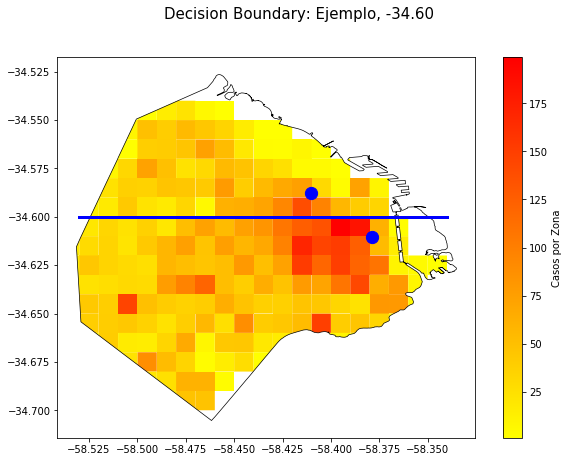

In [47]:
# Tacuari 198 = (-34.610357, -58.378970)
# Alto Palermo = (-34.587686, -58.410279)
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue')
ax.plot(x_set,y_set,c='blue',linewidth=3)
fig.suptitle('Decision Boundary: Ejemplo, -34.60',size=15)
plt.show()

Cómo elegimos la mejor longitud para hacer la separación? Será tal que la diferencia entre los casos al Norte y al Sur sea mínima. Nótese que el grado de imprecisión de los datos nos achica el espacio de búsqueda: iríamos desde -34.61 hasta -34.58 (longitudes de los centros de Juzgados). Podemos extendernos un poco más para tener más puntos de comparación.

In [48]:
def casos_longitud(longitud):
    casos_totales = geo_df.shape[0]
    casos_Norte = geo_df[geo_df.den_longitud >= longitud].shape[0]
    casos_Sur = casos_totales - casos_Norte
    return (casos_totales, casos_Norte, casos_Sur)

In [49]:
casos_df = pd.DataFrame()
longitudes = [-34.64 + i*0.01 for i in range(7)]
casos_df['longs'] = longitudes
for j in range(7):
    casos_df.at[j,'totales'] = casos_longitud(longitudes[j])[0]
    casos_df.at[j,'Norte'] = casos_longitud(longitudes[j])[1]
    casos_df.at[j,'Sur'] = casos_longitud(longitudes[j])[2]
    casos_df.at[j,'Dif'] = abs(casos_df.at[j,'Norte'] - casos_df.at[j,'Sur'])
casos_df

,longs,totales,Norte,Sur,Dif
0,-34.64,10100.0,8406.0,1694.0,6712.0
1,-34.63,10100.0,7451.0,2649.0,4802.0
2,-34.62,10100.0,6272.0,3828.0,2444.0
3,-34.61,10100.0,5036.0,5064.0,28.0
4,-34.60,10100.0,3747.0,6353.0,2606.0
5,-34.59,10100.0,2461.0,7639.0,5178.0
6,-34.58,10100.0,1648.0,8452.0,6804.0


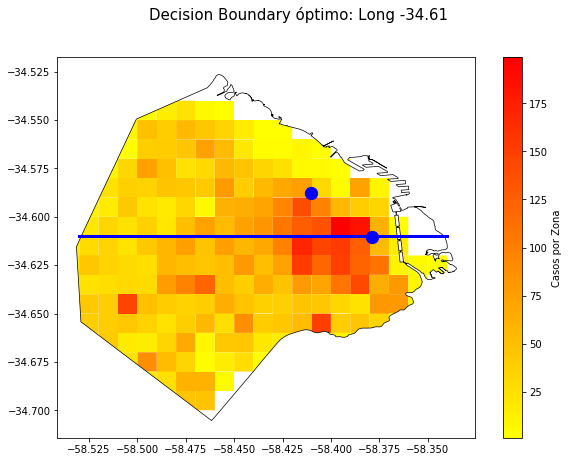

In [50]:
# Ploteamos el valor óptimo, i.e., el que minimiza la diferencia
minimo = casos_df['Dif'].min()
long_opt = float(casos_df[casos_df['Dif'] == minimo]['longs'].values)
y_set = long_opt + 0*x_set
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],y=[-34.610357,-34.587686],s=150,c='blue')
ax.plot(x_set,y_set,c='blue',linewidth=3)
fig.suptitle('Decision Boundary óptimo: Long '+str(long_opt),size=15)
plt.show()

### Propuesta: decision boundary longitud, criterio fojas

En este apartado, el mismo análisis pero tomando como función de "carga de trabajo" la cantidad de fojas (totales) por zona.

In [51]:
fojas_geometry = geo_df_pd.groupby('str_geometry').sum()['exp_fojas']
fojas_geometry = fojas_geometry.to_frame().reset_index(drop=False)
fojas_geo_df = gpd.GeoDataFrame(fojas_geometry['exp_fojas'],
                                geometry=fojas_geometry['str_geometry'].apply(wkt.loads))
fojas_geo_df.head()

,exp_fojas,geometry
0,462,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,161,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,193,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,1,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6..."


In [52]:
def fojas_longitud(longitud):
    fojas_totales = geo_df.exp_fojas.sum()
    fojas_Norte = geo_df[geo_df.den_longitud >= longitud].exp_fojas.sum()
    fojas_Sur = fojas_totales - fojas_Norte
    return (fojas_totales, fojas_Norte, fojas_Sur)

In [53]:
fojas_df = pd.DataFrame()
longitudes = [-34.64 + i*0.01 for i in range(7)]
fojas_df['longs'] = longitudes
for j in range(7):
    fojas_df.at[j,'totales'] = fojas_longitud(longitudes[j])[0]
    fojas_df.at[j,'Norte'] = fojas_longitud(longitudes[j])[1]
    fojas_df.at[j,'Sur'] = fojas_longitud(longitudes[j])[2]
    fojas_df.at[j,'Dif'] = abs(fojas_df.at[j,'Norte'] - fojas_df.at[j,'Sur'])
fojas_df

,longs,totales,Norte,Sur,Dif
0,-34.64,304009.0,257592.0,46417.0,211175.0
1,-34.63,304009.0,220661.0,83348.0,137313.0
2,-34.62,304009.0,187794.0,116215.0,71579.0
3,-34.61,304009.0,152799.0,151210.0,1589.0
4,-34.60,304009.0,113628.0,190381.0,76753.0
5,-34.59,304009.0,72643.0,231366.0,158723.0
6,-34.58,304009.0,48140.0,255869.0,207729.0


La longitud óptima en cantidad de casos y en fojas es la misma: -34.61

### Propuesta: Decision Boundary oblicuo

En este apartado investigamos la misma idea con una función lineal.

In [54]:
# calculo ordenada al origen
ordenada = -34.6 + 58.4

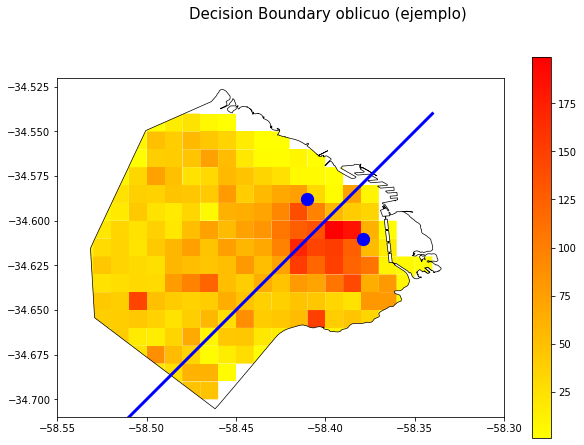

In [55]:
# Tacuari 198 = (-34.610357, -58.378970)
# Alto Palermo = (-34.587686, -58.410279)
y_set = ordenada + x_set
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue')
ax.plot(x_set,y_set,c='blue',
        linewidth=3)
ax.set_xlim(-58.55,-58.30)
ax.set_ylim(-34.71,-34.52)
fig.suptitle('Decision Boundary oblicuo (ejemplo)',size=15)
plt.show()

<b>Pendiente</b>: elegir decision boundary lineal "óptimo" (qué sería óptimo?; tengo dos grados de libertad y un criterio).

### Propuesta: distribución por comunas

Dada la distribución administrativa de la Ciudad de Buenos Aires en Comunas, una posibilidad es establecer el decision boundary en función de esta división existente (de hecho, la distribución actual por Zonas hace uso de este criterio). Esta idea presenta algunas dificultades: la grilla sugerida por el truncamiento no estará geométricamente alineada con las Comunas, lo que dará lugar a una cierta ambigüedad para asignar causas a Comunas.

Empezamos por plotear las Comunas.

In [56]:
# Creamos polígonos de las Comunas 
# con la función unary union de Shapely
comunas = map_df.comuna.unique()
comunas_geometry = []
for comuna in comunas:
    barrios = [map_df.at[i,'geometry'] for i in range(map_df.shape[0]) if map_df.at[i,'comuna'] == comuna]
    geometry = unary_union(barrios)
    comunas_geometry.append(geometry)

comunas_df = gpd.GeoDataFrame()
comunas_df['Comuna'] = comunas
comunas_df['geometry'] = comunas_geometry
comunas_df.head()

,Comuna,geometry
0,15,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
1,11,"POLYGON ((-58.48192 -34.62429, -58.48274 -34.6..."
2,5,"POLYGON ((-58.41178 -34.63036, -58.41178 -34.6..."
3,6,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
4,10,"POLYGON ((-58.48781 -34.64130, -58.48804 -34.6..."


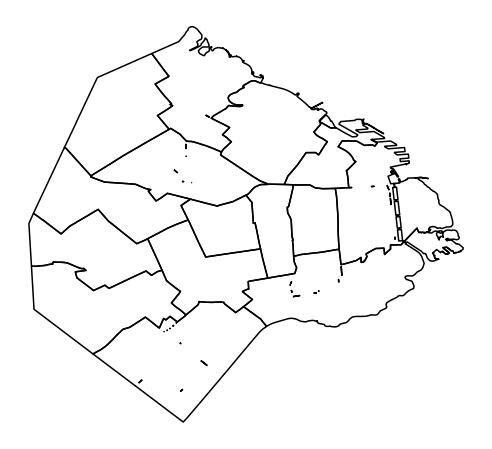

In [57]:
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

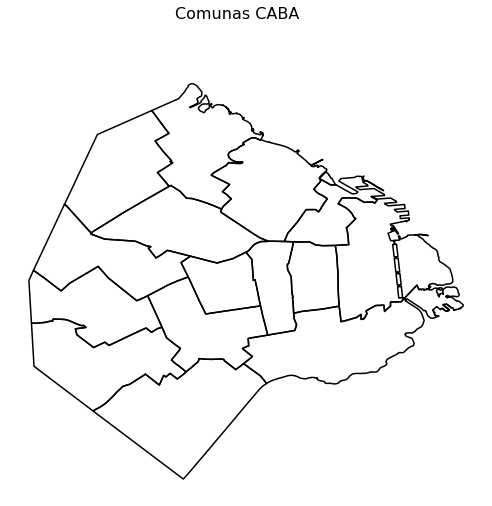

In [58]:
# Pequeña correcion a la geometría
epsilon = 10**(-12)
comunas_df['geometry'] = comunas_df['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
fig.suptitle('Comunas CABA',fontsize=16)
plt.show()

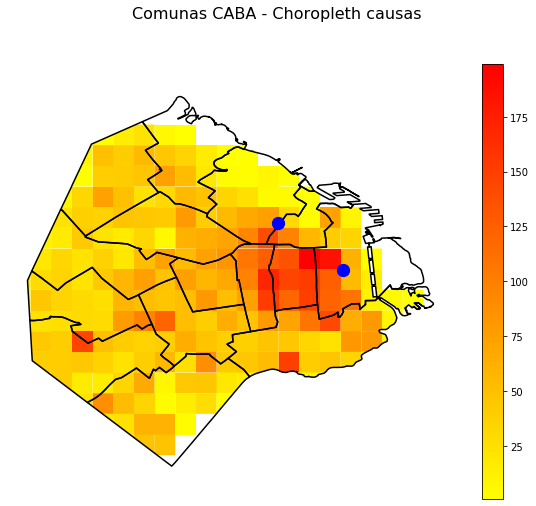

In [59]:
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
casos_geo_df.plot(ax=ax,column='casos',zorder=1,legend=True,cmap='autumn_r')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue',zorder=2)
ax.axis('off')
fig.suptitle('Comunas CABA - Choropleth causas',fontsize=16)
plt.show()

Para establecer la cantidad de causas por Comuna, vamos a asignarles un valor ponderado según el área de solapamiento con los cuadrados geográficos en los que tenemos el dato de causas. Esto supone una distribución uniforme dentro de cada cuadrado, pero naturalmente está sujeto a error. Mientras mayor sea el ratio perímetro / área de una Comuna, mayor será el error cometido.

In [60]:
# Distribuyo el total de por cuadrado casos 
# Asigno el proporcional a cada comuna
casos_comunasdf = comunas_df
for i in range(15):
    casos = []
    geometry_comuna = casos_comunasdf.at[i,'geometry']
    for j in range(casos_geo_df.shape[0]):
        polygon = casos_geo_df.at[j,'geometry']
        area_polygon = polygon.area
        area_intersect = geometry_comuna.intersection(polygon).area
        casos_intersect = area_intersect*casos_geo_df.at[j,'casos'] / area_polygon
        casos.append(casos_intersect)
    casos_comunasdf.at[i,'Casos'] = np.sum(np.array(casos))
casos_comunasdf

,Comuna,geometry,Casos
0,15,"POLYGON ((-58.50331 -34.59386, -58.50214 -34.5...",674.638344
1,11,"POLYGON ((-58.52934 -34.61098, -58.52940 -34.6...",553.736366
2,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",708.642627
3,6,"POLYGON ((-58.46251 -34.60724, -58.46215 -34.6...",452.713533
4,10,"POLYGON ((-58.53080 -34.62752, -58.53152 -34.6...",582.803506
5,7,"POLYGON ((-58.47701 -34.62408, -58.47741 -34.6...",696.036501
6,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",913.157266
7,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...",923.282676
8,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...",1297.681220
9,9,"POLYGON ((-58.52854 -34.63486, -58.52821 -34.6...",787.374596


In [61]:
# Check
print('Casos Comunas: '+str(casos_comunasdf['Casos'].sum()))
print('Casos Totales: '+str(casos_geo_df['casos'].sum()))

Casos Comunas: 10099.99999647589
Casos Totales: 10100


In [62]:
# Agrego una coordenada de cada polígono al geoDataFrame
# esto es para los labels del mapa
casos_comunasdf['coords'] = casos_comunasdf['geometry'].apply(lambda x: x.representative_point().coords[:])
casos_comunasdf['coords'] = [coords[0] for coords in comunas_df['coords']]
casos_comunasdf.head()

,Comuna,geometry,Casos,coords
0,15,"POLYGON ((-58.50331 -34.59386, -58.50214 -34.5...",674.638344,"(-58.46681471374262, -34.590124613200004)"
1,11,"POLYGON ((-58.52934 -34.61098, -58.52940 -34.6...",553.736366,"(-58.50082020879522, -34.6029645141)"
2,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",708.642627,"(-58.420549629235715, -34.618844705149996)"
3,6,"POLYGON ((-58.46251 -34.60724, -58.46215 -34.6...",452.713533,"(-58.443458670551706, -34.6168738474)"
4,10,"POLYGON ((-58.53080 -34.62752, -58.53152 -34.6...",582.803506,"(-58.50312909088126, -34.627489216049995)"


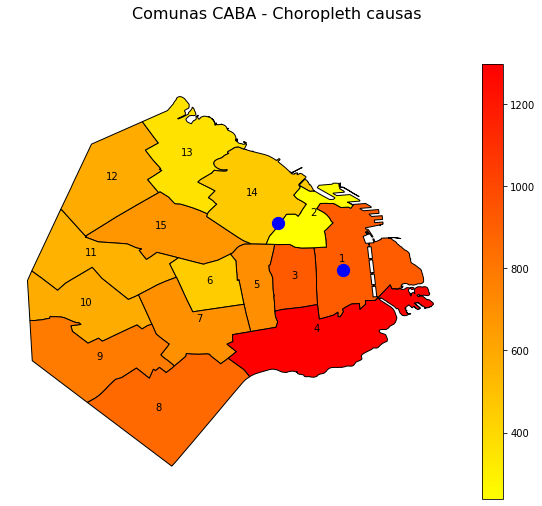

In [63]:
fig, ax = plt.subplots(1, figsize=(10, 8))
casos_comunasdf.plot(ax=ax,edgecolor='0',column='Casos',
                legend=True,cmap='autumn_r')
# Labeleo el nombre a cada comuna
for idx, row in comunas_df.iterrows():
    plt.annotate(s=row['Comuna'], xy=row['coords'],
                 horizontalalignment='center')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue',zorder=2)
ax.axis('off')
fig.suptitle('Comunas CABA - Choropleth causas',fontsize=16)
plt.show()

Aquí se ven dos variables en juego: la densidad geográfica de casos y el área de cada Comuna. Ejemplo: la Comuna 3 tiene más causas por m2, pero la Comuna 4 es más grande, de modo que termina teniendo más casos totales.

Text(0.5, 1.0, 'Casos por Comuna')

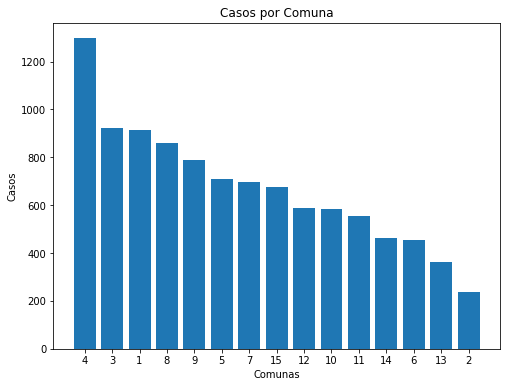

In [64]:
# Ploteamos casos por Comuna
plt.figure(figsize=(8,6))
comunas_sort = comunas_df.sort_values(by='Casos',ascending=False)
plt.bar(x=comunas_sort['Comuna'],height=comunas_sort['Casos'])
plt.xlabel('Comunas')
plt.ylabel('Casos')
plt.title('Casos por Comuna')

El trabajo a continuación consistiría en encontrar combinaciones de Comunas que sean geográficamente coherentes y que sumen una cantidad de casos similar. Eso me resultó más cómodo probarlo en Excel.

In [65]:
casos_comunasdf.to_excel('comunas_df.xlsx') 

Un ejemplo de propuesta sería el siguiente: Comunas 4, 1, 8, 9, 5 y 7 a Tacuarí, el resto a Alto Palermo. Ploteo la idea.

In [66]:
casos_comunasdf['Juzgados'] = "Alto Palermo"
for i in range(comunas_df.shape[0]):
    if casos_comunasdf.at[i,'Comuna'] in ['4','1','8','9','5','7']:
        casos_comunasdf.at[i,'Juzgados'] = "Tacuarí"
casos_comunasdf.head(7)

,Comuna,geometry,Casos,coords,Juzgados
0,15,"POLYGON ((-58.50331 -34.59386, -58.50214 -34.5...",674.638344,"(-58.46681471374262, -34.590124613200004)",Alto Palermo
1,11,"POLYGON ((-58.52934 -34.61098, -58.52940 -34.6...",553.736366,"(-58.50082020879522, -34.6029645141)",Alto Palermo
2,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",708.642627,"(-58.420549629235715, -34.618844705149996)",Tacuarí
3,6,"POLYGON ((-58.46251 -34.60724, -58.46215 -34.6...",452.713533,"(-58.443458670551706, -34.6168738474)",Alto Palermo
4,10,"POLYGON ((-58.53080 -34.62752, -58.53152 -34.6...",582.803506,"(-58.50312909088126, -34.627489216049995)",Alto Palermo
5,7,"POLYGON ((-58.47701 -34.62408, -58.47741 -34.6...",696.036501,"(-58.44834809731838, -34.63526070465)",Tacuarí
6,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...",913.157266,"(-58.37920119008943, -34.605895270000005)",Tacuarí


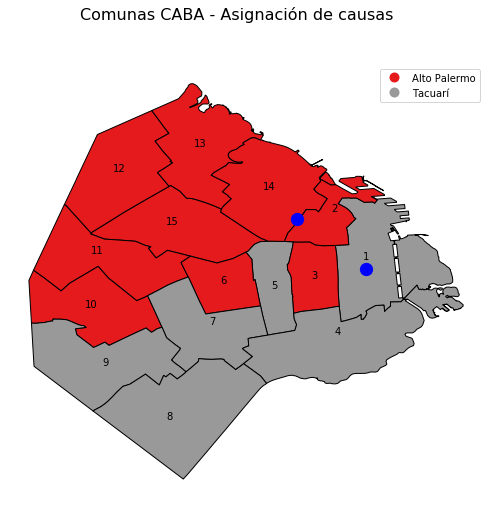

In [67]:
fig, ax = plt.subplots(1, figsize=(10, 8))
casos_comunasdf.plot(ax=ax,edgecolor='0',
                column='Juzgados',cmap='Set1',
               legend=True)
# Labeleo el nombre a cada comuna
for idx, row in comunas_df.iterrows():
    plt.annotate(s=row['Comuna'], xy=row['coords'],
                 horizontalalignment='center')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue',zorder=2)
ax.axis('off')
fig.suptitle('Comunas CABA - Asignación de causas',fontsize=16)
plt.show()

In [68]:
total_tacuari = comunas_df[comunas_df['Juzgados'] == 'Tacuarí']['Casos'].sum()
total_tacuari

5262.212417105337

In [69]:
total_Apalermo = comunas_df[comunas_df['Juzgados'] == 'Alto Palermo']['Casos'].sum()
total_Apalermo

4837.78757937055

In [70]:
diferencia = total_tacuari - total_Apalermo
diferencia

424.4248377347876

La otra observación pertinente es que utilizar los barrios como variable de distribución (en lugar de las Comunas) nos daría más la posibilidad de hilar más fino (sobre todo en las Comunas que explican la mayoría de los casos, como la 5, la 3, la 4). A la vez, la imprecisión de las coordenadas sería un problema mayor.

Por otro lado, este misma distribución en base a locaciones geográficas se puede hacer con otra variable de "carga de trabajo", como fojas totales.

## Robustez de la distribución geográfica

Una cuestión importante a considerar es la representatividad de la distribución geográfica de causas que estamos considerando, teniendo en cuenta que la gran mayoría de las muestras carecen de coordenadas. Se me ocurren dos cuestiones a estudiar: por un lado, comparar este mapa de causas con el "Mapa del Delito" que confecciona la Ciudad de Buenos Aires. En ese caso son delitos denunciados en Comisarías, con lo cual habría que tomar en cuenta solamente aquellos que sean competencia de los Juzgados que estamos considerando (muchos no lo son, por lo que explicaba el juez Casas).

La otra cuestión tiene que ver con la cantidad de NaNs que tiene nuestro dataset en las coordenadas ("unknowns"). Una pregunta importante es si estós NaNs dependen de los valores de los otros features, en qué medida, y qué implica eso para las propuestas. Lo exploramos a continuación.

### Distribución de coordenadas NaNs por juzgado

In [71]:
df[df.org_cod_pri == 'JUZP01'].shape[0]

1094

In [72]:
df2 = df[df.org_cod_pri == 'JUZP01']
df2[df2.den_latitud == 'unknown'].shape[0]

672

In [73]:
algunos_juzgados = df.org_cod_pri.unique()[0:20]
juz_nans,juz_notnans = [],[]
juz_nans_prop,juz_notnans_prop = [],[]
for juzgado in algunos_juzgados:
    df_aux = df[df.org_cod_pri == juzgado]
    total = df_aux.shape[0]
    nans = df_aux[df_aux.den_latitud == 'unknown'].shape[0]
    juz_nans.append(nans)
    juz_notnans.append(total - nans)
    juz_nans_prop.append(nans/total)
    juz_notnans_prop.append((total-nans)/total)

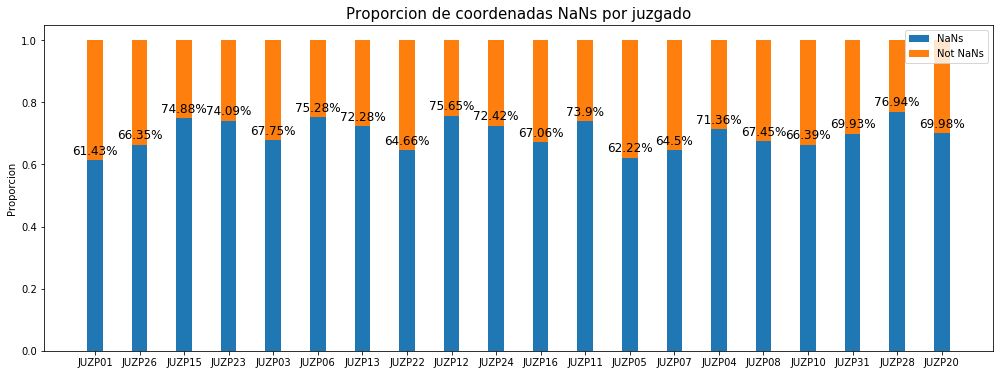

In [74]:
nan_prop = [juz_nans_prop[i] for i in range(len(juz_nans_prop))]
notnan_prop = [juz_notnans_prop[i] for i in range(len(juz_notnans_prop))]
width = 0.35
fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(algunos_juzgados, nan_prop, width, label='NaNs')
rects2 = ax.bar(algunos_juzgados, notnan_prop, width, bottom=nan_prop,
       label='Not NaNs')

for i in range(len(rects1)):
        height = rects1[i].get_height()
        porcentaje = round(nan_prop[i]*100,2)
        str_porc = str(porcentaje) + '%'
        ax.annotate('{}'.format(str_porc),
                    xy=(rects1[i].get_x() + rects1[i].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   size=12)

ax.set_ylabel('Proporcion')
ax.set_title('Proporcion de coordenadas NaNs por juzgado',size=15)
ax.legend()
plt.show()

In [75]:
from scipy.stats import chi2_contingency as chi2

juz_cont = pd.DataFrame(
    [
        juz_nans,
        juz_notnans,
    ],
    index=["NaNs","Not NaNs"],
    columns=algunos_juzgados)

juz_cont = juz_cont.transpose()
juz_cont.head()

,NaNs,Not NaNs
JUZP01,672,422
JUZP26,700,355
JUZP15,966,324
JUZP23,952,333
JUZP03,1172,558


In [76]:
chi2_results = chi2(juz_cont)
chi2_results

(233.3560365950069,
 7.123856401109049e-39,
 19,
 array([[ 766.13235898,  327.86764102],
        [ 738.82051072,  316.17948928],
        [ 903.3919041 ,  386.6080959 ],
        [ 899.89038509,  385.10961491],
        [1211.52557681,  518.47442319],
        [ 883.78339765,  378.21660235],
        [ 785.74086542,  336.25913458],
        [ 824.25757451,  352.74242549],
        [ 831.26061253,  355.73938747],
        [ 904.0922079 ,  386.9077921 ],
        [ 771.73478939,  330.26521061],
        [1207.323754  ,  516.676246  ],
        [ 708.00714344,  302.99285656],
        [ 785.04056162,  335.95943838],
        [ 914.59676492,  391.40323508],
        [ 778.73782741,  333.26217259],
        [ 681.39559898,  291.60440102],
        [ 787.14147303,  336.85852697],
        [ 886.58461286,  379.41538714],
        [ 788.54208063,  337.45791937]]))

In [77]:
print(f'p-value: {chi2_results[1]}')
if chi2_results[1] < 0.05:
    print('Rechazo Ho de independencia')

p-value: 7.123856401109049e-39
Rechazo Ho de independencia


### Distribución de coordenadas NaNs según causas

In [78]:
# Listado de causas por frecuencia de ocurrencia
causas = df['oju_descr'].value_counts()
causas

149 BIS - AMENAZAS                                                                                                    6131
149 BIS  - AMENAZAS - CP (P/ L 2303)                                                                                  5108
183 - DAÑOS                                                                                                           3241
128 1 PARR - DELITOS ATINENTES A LA PORNOGRAFIA (PRODUCIR/PUBLICAR IMAGENES PORNOGR. C MENORES 18)                    2800
89  - LESIONES LEVES                                                                                                  1989
                                                                                                                      ... 
238BIS 1°PARR - ATENTADO DE MILITAR QUE PONE SUS MANOS EN EL SUPERIOR / SIN LESIONARLO O CAUSÁNDOLE LESIONES LEVES       1
173 1 - ESTAFA EN LA SUSTANCIA / CALIDAD O CANTIDAD DE COSAS                                                             1
299  - INTRODUCI

In [79]:
causas_frecuentes = causas.index[0:20]
causas_short = []
for i in range(20):
    causa_string = str(i)+' - '+causas.index[i][0:7]
    causas_short.append(causa_string)
causas_prop = []
for causa in causas_frecuentes:
    df_aux = df[df.oju_descr == causa]
    total = df_aux.shape[0]
    nans = df_aux[df_aux.den_latitud == 'unknown'].shape[0]
    proporciones = (nans / total,(total-nans) / total)
    causas_prop.append(proporciones)

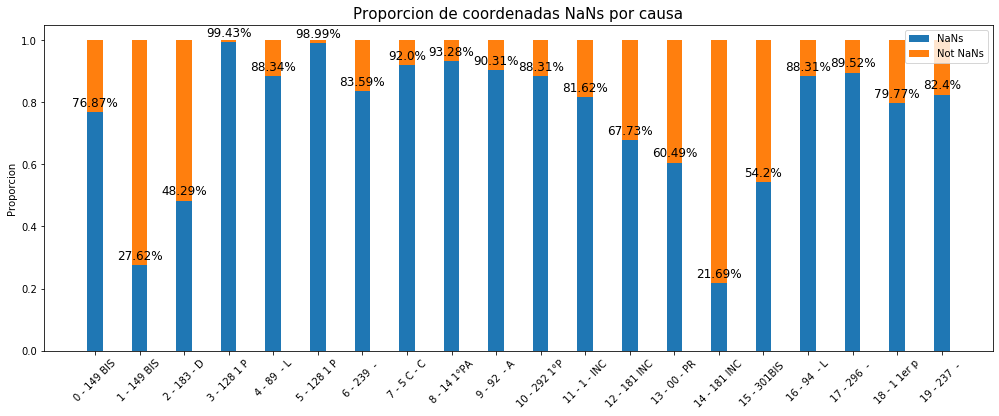

In [80]:
nan_prop = [causas_prop[i][0] for i in range(len(causas_prop))]
notnan_prop = [causas_prop[i][1] for i in range(len(causas_prop))]
width = 0.35
fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(causas_short, nan_prop, width, label='NaNs')
rects2 = ax.bar(causas_short, notnan_prop, width, bottom=nan_prop,
       label='Not NaNs')

for i in range(len(rects1)):
        height = rects1[i].get_height()
        porcentaje = round(nan_prop[i]*100,2)
        str_porc = str(porcentaje) + '%'
        ax.annotate('{}'.format(str_porc),
                    xy=(rects1[i].get_x() + rects1[i].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   size=12)

for tick in ax.get_xticklabels():
        tick.set_rotation(45)

ax.set_ylabel('Proporcion')
ax.set_title('Proporcion de coordenadas NaNs por causa',size=15)
ax.legend()
plt.show()

Este es un panorama mucho más heterogéneo que habrá que estudiar en detalle para poder asignar las causas con un criterio razonable. Además de la heterogeneidad, es interesante la diferencia entre los dos primero delitos, cuya descripción es muy parecida (será que uno son amenazas teléfonicas / virtuales y el otro presenciales? - preguntar). 

## Comparación entre Zonas judiciales

### Mapa Zonas Judiciales

Recordamos que la zonificación de los juzgados de primera instancia, responde al siguiente mapeo de comunas (Resolución FG Nº 181-18)

Zona A: al Norte compuesto por las comunas 12, 13, 14, y 15;
Zona B: al Este compuesto por las comunas 1, 2, 3, y 5;
Zona C: al Sur compuesto por las comunas 4, 8, y 9;
Zona D: al Oeste compuesto por las comunas 6, 7, 10, y 11.

In [81]:
def comuna_zona(comuna):
    if comuna in [12,13,14,15]:
        return 'A'
    elif comuna in [1,2,3,5]:
        return 'B'
    elif comuna in [4,8,9]:
        return 'C'
    else:
        return 'D'

In [82]:
map_df['Zona'] = map_df['comuna'].apply(lambda x: comuna_zona(float(x)))
map_df[['barrio','geometry','comuna','Zona']].head()

,barrio,geometry,comuna,Zona
0,CHACARITA,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...",15,A
1,PATERNAL,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...",15,A
2,VILLA CRESPO,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...",15,A
3,VILLA DEL PARQUE,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...",11,D
4,ALMAGRO,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...",5,B


In [83]:
# Creamos polígonos de las zonas judiciales 
zonas = ['A','B','C','D']
zona_geometry = []
for zona in zonas:
    barrios = [map_df.at[i,'geometry'] for i in range(map_df.shape[0]) if map_df.at[i,'Zona'] == zona]
    geometry = unary_union(barrios)
    zona_geometry.append(geometry)

zona_geodf = gpd.GeoDataFrame()
zona_geodf['Zona'] = zonas
zona_geodf['geometry'] = zona_geometry
# Pequeña correcion a la geometría
epsilon = 10**(-12)
zona_geodf['geometry'] = zona_geodf['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
zona_geodf

,Zona,geometry
0,A,"POLYGON ((-58.51452 -34.58174, -58.51457 -34.5..."
1,B,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6..."
2,C,"POLYGON ((-58.52854 -34.63486, -58.52821 -34.6..."
3,D,"POLYGON ((-58.53080 -34.62752, -58.53152 -34.6..."


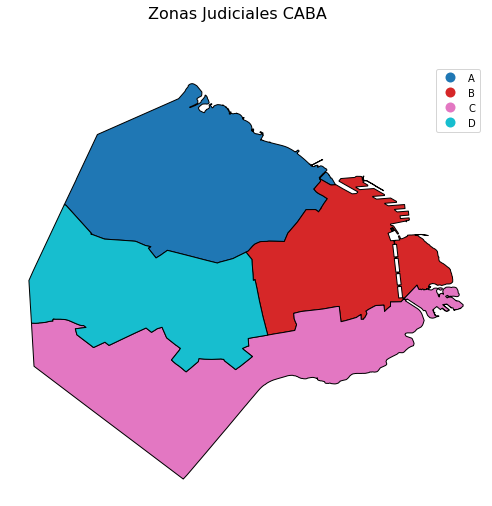

In [84]:
fig, ax = plt.subplots(1, figsize=(10, 8))
zona_geodf.plot(ax=ax,edgecolor='0',column='Zona',legend=True)
ax.axis('off')
fig.suptitle('Zonas Judiciales CABA',fontsize=16)
plt.show()

Una cuestión que nos gustaría estudiar es la distribución de nuestras variables (cantidad de casos, duración, extensión) según la Zona en que caen. El problema con esto es que la ambigüedad de la información geográfica es un impedimento para computar correctamente medidas estadísticas de comparación. Para poder lidiar con este problema, en el siguiente apartado vamos a asignar los casos a sus zonas con diferente grado de certeza. 

La idea es la siguiente: un caso estará dentro de una Zona si el área correspondiente está contenida en esa zona. Como habrá muchos casos que se solapan con más de una Zona a la vez, tomaremos criterios de solapamiento del 98% (bajo error, mucho desperdicio de información), 75% y 50% (alto error, poco desperdicio de información). Las conclusiones que podamos sacar estarán limitadas por estas imprecisiones.

In [85]:
# Función de intersección
def polygon_in_polygon(contained,container,tolerance):
    overlap = contained.intersection(container).area / contained.area
    if overlap > tolerance:
        return True
    else: 
        return False

In [86]:
def create_Zona_column(tolerance):
    string = str(tolerance)
    name = 'Zona'+string[1:len(string)]
    geo_df[name] = ''
    for i in range(geo_df.shape[0]):
        contained = geo_df.at[i,'geometry']
        for j in range(4):
            container = zona_geodf.at[j,'geometry']
            if polygon_in_polygon(contained,container,tolerance) == True:
                geo_df.loc[i,name] = zona_geodf.at[j,'Zona']
                break
        else:
            geo_df.loc[i,name] = 'Ambigua'    

In [87]:
create_Zona_column(0.98)
create_Zona_column(0.75)
create_Zona_column(0.5)

### Cantidad de casos en cada Zona

In [88]:
print(geo_df['Zona.98'].value_counts())
print(geo_df['Zona.75'].value_counts())
print(geo_df['Zona.5'].value_counts())

Ambigua    2595
C          2138
B          2064
A          1700
D          1603
Name: Zona.98, dtype: int64
B          2626
C          2478
D          1889
A          1855
Ambigua    1252
Name: Zona.75, dtype: int64
C    3001
B    2869
D    2224
A    2006
Name: Zona.5, dtype: int64


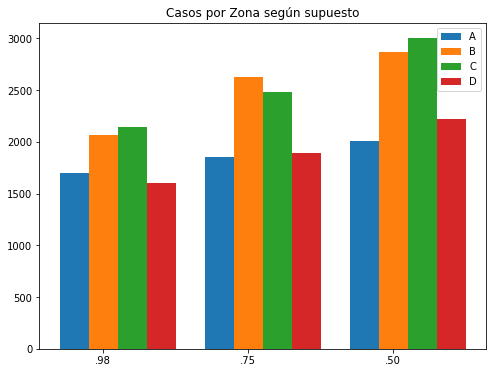

In [89]:
# Gráficamente
labels = ['.98','.75','.50']
values_98 = geo_df['Zona.98'].value_counts()
values_75 = geo_df['Zona.75'].value_counts()
values_50 = geo_df['Zona.5'].value_counts()
zonas = ['A','B','C','D']
casos_zona = []
for zona in zonas:
    lista = []
    lista.append(values_98[zona])
    lista.append(values_75[zona])
    lista.append(values_50[zona])
    casos_zona.append(lista)
    
fig, ax = plt.subplots(figsize=(8,6))
ind = np.arange(3)    # the x locations for the groups
width = 0.20        # the width of the bars
ax.bar(ind, casos_zona[0], width, label='A')
ax.bar(ind + width, casos_zona[1], width,label='B')
ax.bar(ind + 2*width, casos_zona[2], width, label='C')
ax.bar(ind + 3*width, casos_zona[3], width, label='D')

ax.set_title('Casos por Zona según supuesto')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(labels))
ax.legend()
plt.show()

La única (humilde) conclusión que podemos sacar es que la Zona B tiene más casos que las demás. Lo otro notorio es cómo aumentan la cantidad de casos en la Zona C a medida que relajamos los supuestos de intersección. Esto es probablemente consecuencia de que la Zona C tiene la "frontera" más extensa (dando lugar a más casos geográficamente ambiguos).

### Cantidad de fojas por Zona

In [90]:
print(geo_df.groupby('Zona.98').count()[['exp_cuerpos','exp_fojas']])
print(geo_df.groupby('Zona.75').count()[['exp_cuerpos','exp_fojas']])
print(geo_df.groupby('Zona.5').count()[['exp_cuerpos','exp_fojas']])

         exp_cuerpos  exp_fojas
Zona.98                        
A               1700       1700
Ambigua         2595       2595
B               2064       2064
C               2138       2138
D               1603       1603
         exp_cuerpos  exp_fojas
Zona.75                        
A               1855       1855
Ambigua         1252       1252
B               2626       2626
C               2478       2478
D               1889       1889
        exp_cuerpos  exp_fojas
Zona.5                        
A              2006       2006
B              2869       2869
C              3001       3001
D              2224       2224


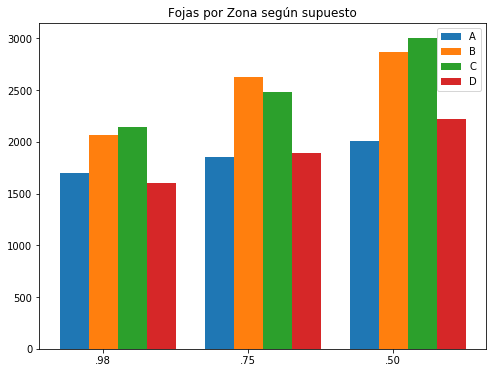

In [91]:
# Gráficamente
labels = ['.98','.75','.50']
fojas_98 = geo_df.groupby('Zona.98').count()['exp_fojas']
fojas_75 = geo_df.groupby('Zona.75').count()['exp_fojas']
fojas_50 = geo_df.groupby('Zona.5').count()['exp_fojas']
zonas = ['A','B','C','D']
fojas_zona = []
for zona in zonas:
    lista = []
    lista.append(fojas_98[zona])
    lista.append(fojas_75[zona])
    lista.append(fojas_50[zona])
    fojas_zona.append(lista)
    
fig, ax = plt.subplots(figsize=(8,6))
ind = np.arange(3)    # the x locations for the groups
width = 0.20        # the width of the bars
ax.bar(ind, fojas_zona[0], width, label='A')
ax.bar(ind + width, fojas_zona[1], width,label='B')
ax.bar(ind + 2*width, fojas_zona[2], width, label='C')
ax.bar(ind + 3*width, fojas_zona[3], width, label='D')

ax.set_title('Fojas por Zona según supuesto')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(labels))
ax.legend()
plt.show()

Conclusiones similares a lo anterior.

### Tamaño promedio de los casos por zona (en fojas)

Vamos a estudiar el tamaño promedio de los casos, medido en fojas. Primero sacaremos los casos con una sola foja (que son la mayoría).

In [92]:
geo_df[geo_df['exp_fojas'] == 1].shape

(5898, 65)

In [93]:
print(geo_df[geo_df['exp_fojas'] > 1].groupby('Zona.98').mean()[['exp_cuerpos','exp_fojas']])
print(geo_df[geo_df['exp_fojas'] > 1].groupby('Zona.75').mean()[['exp_cuerpos','exp_fojas']])
print(geo_df[geo_df['exp_fojas'] > 1].groupby('Zona.5').mean()[['exp_cuerpos','exp_fojas']])

         exp_cuerpos  exp_fojas
Zona.98                        
A           1.058997  70.325959
Ambigua     1.058877  71.726449
B           2.169632  72.750890
C           1.116173  69.039863
D           1.103004  70.526466
         exp_cuerpos  exp_fojas
Zona.75                        
A           1.055021  69.125172
Ambigua     1.058824  76.631488
B           1.933953  71.826977
C           1.103550  68.411243
D           1.101485  70.521040
        exp_cuerpos  exp_fojas
Zona.5                        
A          1.053367  69.612452
B          1.861369  72.131023
C          1.088993  69.579235
D          1.094637  72.412198


Pareciera que la Zona B tiene casos más largos (medidos en fojas). Pendiente: ANOVA para evaluar la significatividad y entender a qué se debería: tiene que ver con el tipo de casos o el tipo de juzgados? De todos modos. aún cuando fueran significativas, las diferencias no son grandes.

Por otro lado, me interesa medir la variabilidad.

In [94]:
print(geo_df.groupby('Zona.98').std()[['exp_cuerpos','exp_fojas']])
print(geo_df[geo_df['exp_fojas'] > 1].groupby('Zona.75').std()[['exp_cuerpos','exp_fojas']])
print(geo_df[geo_df['exp_fojas'] > 1].groupby('Zona.5').std()[['exp_cuerpos','exp_fojas']])

         exp_cuerpos  exp_fojas
Zona.98                        
A           0.330034  56.371703
Ambigua     0.277234  59.086020
B          20.098075  72.600921
C           1.136805  60.191419
D           6.719679  63.329131
         exp_cuerpos  exp_fojas
Zona.75                        
A           0.503157  69.825990
Ambigua     0.348306  78.038968
B          27.848959  94.565791
C           1.140707  75.442397
D           0.594979  79.111137
        exp_cuerpos  exp_fojas
Zona.5                        
A          0.486142  70.102313
B         26.547905  94.665413
C          1.019289  73.149580
D          0.559589  80.727967


Esto me está indicando un coeficiente de variabilidad de alrededor del 130% para la Zona B, y de aprox 100% para el resto. Esto creo que es interesante para analizar la eficiencia del trabajo en cada causa. Arriba filtramos las causas con una foja, pero verlas en detalle es ilustrativo.

In [95]:
geo_df[geo_df['exp_fojas'] == 1].groupby('Zona.98').count()['exp_fojas']

Zona.98
A          1022
Ambigua    1491
B          1221
C          1260
D           904
Name: exp_fojas, dtype: int64

### Duración de los casos por zona

Pendiente: análisis similar para la "duración" de los casos por zona, sumando las columnas de tiempo.

## Filtros

Dado el grado de imprecisión en los datos, lo que podemos plotear en un mapa es bastante limitado. Elijo aquí algunos filtros como ejemplo, dejando abierta la posibilidad de estudiar otros a futuro. 

### Causas

Empecemos por conocer el tamaño promedio de las causas.

In [96]:
geo_df['exp_fojas'].mean()

30.09990099009901

Abajo un query un poco largo (perdón), lo que quiero es ver la media de fojas ('exp_fojas') y la cantidad de causas por tipo de delito ('oju_descr'). 'oju_id' es para tener un nombre más corto.

In [97]:
delitos = geo_df.groupby(['oju_id','oju_descr']).agg(['mean', 'count','sum'])
delitos['exp_fojas'].sort_values(by='sum',ascending=False).head(10)

,,mean,count,sum
oju_id,oju_descr,,,
580,149 BIS - AMENAZAS,35.742349,1405,50218
211,149 BIS - AMENAZAS - CP (P/ L 2303),15.331986,3217,49323
217,183 - DAÑOS,23.907671,1473,35216
1353,301BIS - JUEGOS DE AZAR SIN AUTORIZACION PERTINENTE,104.953488,172,18052
1615,239 - RESISTENCIA O DESOBEDIENCIA A LA AUTORIDAD,41.670588,255,10626
582,181 INC. 1 - USURPACION (DESPOJO),54.677019,161,8803
1391,89 - LESIONES LEVES,35.271552,232,8183
189,00 - PRESUNTA COMISION DELITO (COMPETENCIA),43.631868,182,7941
214,181 INC. 1 - USURPACION (DESPOJO) - CP (P/ L 2303),20.761610,323,6706


Ploteamos un delito de tamaño manejable (es decir, no demasiadas instancias), pero que implique una buena cantidad de trabajo (total de fojas, es decir <b>sum</b>).

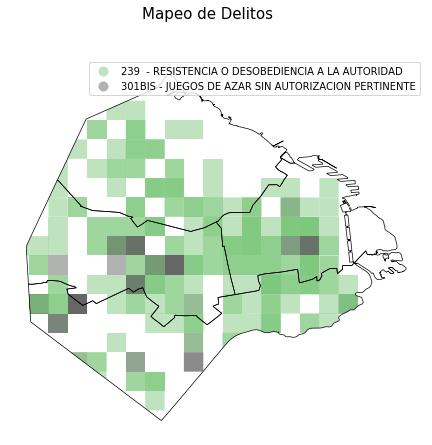

In [98]:
fig, ax = plt.subplots(1, figsize=(10, 7))
zona_geodf.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
geo_df[geo_df['oju_id'].isin([1615,1353])].plot(ax=ax,alpha=0.5,zorder=1,cmap='Accent',
                                                column='oju_descr',legend=True)
fig.suptitle('Mapeo de Delitos',size=15)
ax.axis('off')
plt.show()

### Ideas WIP Backup

In [99]:
# Agregamos data a nuestro geodf
for i in range(4):    
    zona_geodf.at[i,'Casos.98'] = casos_zona[i][0]
    zona_geodf.at[i,'Casos.75'] = casos_zona[i][1]
    zona_geodf.at[i,'Casos.50'] = casos_zona[i][2]
zona_geodf

,Zona,geometry,Casos.98,Casos.75,Casos.50
0,A,"POLYGON ((-58.51452 -34.58174, -58.51457 -34.5...",1700.0,1855.0,2006.0
1,B,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...",2064.0,2626.0,2869.0
2,C,"POLYGON ((-58.52854 -34.63486, -58.52821 -34.6...",2138.0,2478.0,3001.0
3,D,"POLYGON ((-58.53080 -34.62752, -58.53152 -34.6...",1603.0,1889.0,2224.0


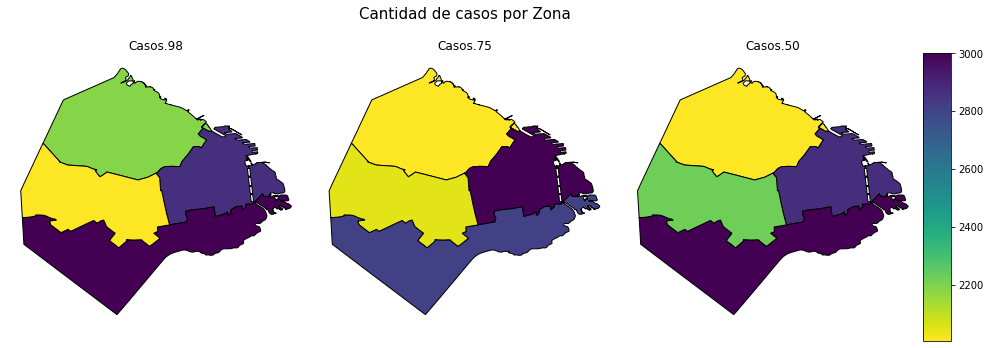

In [100]:
# veámoslo en un mapa
columnas = ['Casos.98','Casos.75','Casos.50']
colormap = "copper_r"
fig, ax = plt.subplots(1,3, figsize=(13,8))
for i in range(3):    
    zona_geodf.plot(ax=ax[i],edgecolor='0',column=columnas[i],cmap='viridis_r')
    ax[i].set_title(columnas[i])
    ax[i].axis('off')
    
figura = ax[0].get_figure()
# add colorbar axes to the figure
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = figura.add_axes([0.99, 0.4, 0.03, 0.5])   
# cbax.set_title('Population')
sm = plt.cm.ScalarMappable(cmap='viridis_r',
                norm=plt.Normalize(vmin=min(zona_geodf[columnas[i]]), vmax=max(zona_geodf[columnas[i]])))
# at this stage, 
# 'cbax' is just a blank axes, with un needed labels on x and y axes
# blank-out the array of the scalar mappable 'sm'
# sm._A = []
# draw colorbar into 'cbax'
figura.colorbar(sm, cax=cbax, format="%d")
fig.suptitle('Cantidad de casos por Zona',size=15)
fig.tight_layout()
fig.subplots_adjust(top=1.3)
# plt.show()

In [101]:
time.time() - time_init

429.13097500801086